In [1]:
from scipy.spatial.distance import cosine
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import pickle

In [2]:
df_rus = pd.read_csv('data/russian.csv', sep=';')
df_nord = pd.read_csv('data/nordic.csv', sep=';')
df_match = pd.read_csv('data/match.csv', sep=';')
match_nr = {}
match_rn = {}
for i in df_match.index :
    match_nr[df_match['nord'][i]] = df_match['rus'][i]
    match_rn[df_match['rus'][i]] = df_match['nord'][i]
with open('data/untrained.pkl', 'rb') as f :
    untrained = pickle.load(f)
with open('data/trained_5.pkl', 'rb') as f :
    trained = pickle.load(f)

df_nord_test = df_nord[~df_nord['word'].isin(df_match['nord'].head(45))]
df_rus_test = df_rus[~df_rus['word'].isin(df_match['rus'].head(45))]

In [3]:
import sortedcontainers
match_raw = {}
scores_untrained = []
true_untrained = []

scores_classificator = []
true_classificator = []

for word1 in df_nord_test['word'] : 
    match_raw[word1] = []
    similarities = sortedcontainers.SortedDict()
    for word2 in df_rus_test['word'] :
        similarity = 1 - np.abs(cosine(untrained[word1], untrained[word2]))
        scores_classificator.append(similarity)
        true_classificator.append(1 if (word1, word2) in match_nr.items() else 0)
        similarities[similarity] = word2
    for d, w in reversed(similarities.items()) :
        if len(match_raw[word1]) == 15 :
            break
        if w not in match_raw[word1] :
            match_raw[word1].append(w)
    scores_untrained.append(list(similarities.keys())[-1])
    true_untrained.append(1 if (word1, list(similarities.values())[-1]) in match_nr.items() else 0)

In [4]:
match_final = {}

scores_trained = []
true_trained = []



for word1 in match_raw :
    similarities = [1 - np.abs(cosine(trained[word1], trained[w])) for w in match_raw[word1]]
    max_ind = np.argmax(similarities)
    match_final[word1] = match_raw[word1][max_ind]
    scores_trained.append(similarities[max_ind])
    true_trained.append(1 if (word1, match_raw[word1][max_ind]) in match_nr.items() else 0)

while np.sum(true_trained) < len(match_nr) :
    true_trained.append(1)
    scores_trained.append(0.0)
while np.sum(true_untrained) < len(match_nr) :
    true_untrained.append(1)
    scores_untrained.append(0.0) 

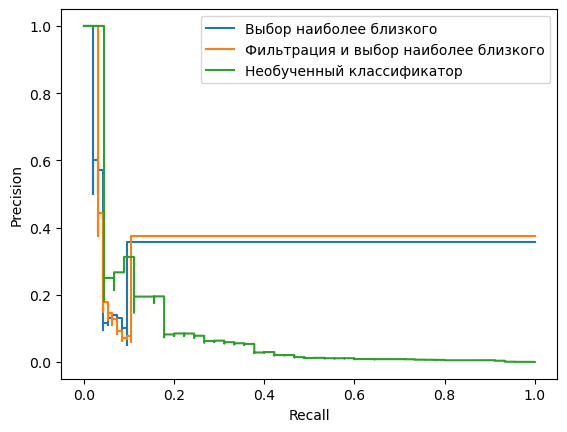

In [5]:
from sklearn import metrics
from matplotlib import pyplot as plt
(prec_u, recall_u, prc_thres_u) = metrics.precision_recall_curve(true_untrained, scores_untrained)
(prec_t, recall_t, prc_thres_t) = metrics.precision_recall_curve(true_trained, scores_trained)
(prec_c, recall_c, prc_thres_c) = metrics.precision_recall_curve(true_classificator, scores_classificator)

fig, ax = plt.subplots()

disp1 = metrics.PrecisionRecallDisplay(prec_u, recall_u)
disp2 = metrics.PrecisionRecallDisplay(prec_t, recall_t)
disp3 = metrics.PrecisionRecallDisplay(prec_c, recall_c)
disp1.plot(ax=ax, name='Выбор наиболее близкого')
disp2.plot(ax=ax, name='Фильтрация и выбор наиболее близкого')
disp3.plot(ax=ax, name='Необученный классификатор')
plt.legend()

In [6]:
def classify(y_score, threshold) :
    y_pred = []
    for y in y_score :
        y_pred.append(1 if y > threshold else 0)
    return y_pred

f_untrained_scores = (np.array([(2 * p * r) / (p + r) for (p, r) in zip(prec_u, recall_u)]))
f_trained_scores = (np.array([(2 * p * r) / (p + r) for (p, r) in zip(prec_t, recall_t)]))
untrained_max = np.argmax(f_untrained_scores)
trained_max = np.argmax(f_trained_scores)
print("One-step:")
print("Best F-score:", f_untrained_scores[untrained_max], "\nPrecision:",
      prec_u[untrained_max], "\nRecall:", recall_u[untrained_max], '\n')
print("Two-step:")
print("Best F-score:", f_trained_scores[trained_max], "\nPrecision:",
      prec_t[trained_max], "\nRecall:", recall_t[trained_max])




One-step:
Best F-score: 0.5248618784530387 
Precision: 0.35580524344569286 
Recall: 1.0 

Two-step:
Best F-score: 0.5459770114942528 
Precision: 0.37549407114624506 
Recall: 1.0


In [7]:
max_recall = np.argmax(recall_u - 1.0)
pred_untrained = classify(scores_untrained, prc_thres_u[max_recall])
df_results = pd.DataFrame(columns=['nord', 'rus', 'true'])
print(np.sum(pred_untrained), len(pred_untrained))

181 267


In [8]:
match_raw1 = {}
scores_untrained1 = []
true_untrained1 = []

scores_classificator1 = []
true_classificator1 = []

for word1 in df_nord['word'] : 
    match_raw1[word1] = []
    similarities = sortedcontainers.SortedDict()
    for word2 in df_rus['word'] :
        similarity = 1 - np.abs(cosine(untrained[word1], untrained[word2]))
        scores_classificator1.append(similarity)
        true_classificator1.append(1 if (word1, word2) in match_nr.items() else 0)
        similarities[similarity] = word2
    for d, w in reversed(similarities.items()) :
        if len(match_raw1[word1]) == 15 :
            break
        if w not in match_raw1[word1] :
            match_raw1[word1].append(w)
    scores_untrained1.append(list(similarities.keys())[-1])
    true_untrained1.append(1 if (word1, list(similarities.values())[-1]) in match_nr.items() else 0)

In [9]:

match_final1 = {}

scores_trained1 = []
true_trained1 = []



for word1 in match_raw1 :
    similarities = [1 - np.abs(cosine(trained[word1], trained[w])) for w in match_raw1[word1]]
    max_ind = np.argmax(similarities)
    match_final1[word1] = similarities[max_ind]
    scores_trained1.append(similarities[max_ind])
    true_trained1.append(1 if (word1, match_raw1[word1][max_ind]) in match_nr.items() else 0)


while np.sum(true_trained1) < len(match_nr) :
    true_trained1.append(1)
    scores_trained1.append(0.0)
while np.sum(true_untrained1) < len(match_nr) :
    true_untrained1.append(1)
    scores_untrained1.append(0.0)


/home/arizenelm/Cloud/Projects/word_distance/env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/arizenelm/Cloud/Projects/word_distance/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


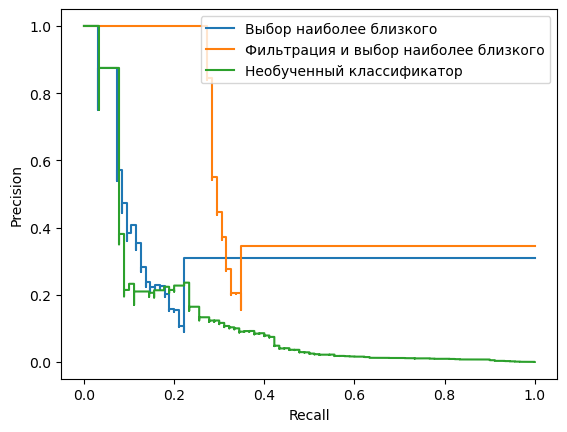

In [10]:

(prec_u1, recall_u1, prc_thres_u1) = metrics.precision_recall_curve(true_untrained1, scores_untrained1)
(prec_t1, recall_t1, prc_thres_t1) = metrics.precision_recall_curve(true_trained1, scores_trained1)
(prec_c1, recall_c1, prc_thres_c1) = metrics.precision_recall_curve(true_classificator1, scores_classificator1)

fig, ax = plt.subplots()

disp1 = metrics.PrecisionRecallDisplay(prec_u1, recall_u1)
disp2 = metrics.PrecisionRecallDisplay(prec_t1, recall_t1)
disp3 = metrics.PrecisionRecallDisplay(prec_c1, recall_c1)
disp1.plot(ax=ax, name='Выбор наиболее близкого')
disp2.plot(ax=ax, name='Фильтрация и выбор наиболее близкого')
disp3.plot(ax=ax, name='Необученный классификатор')
plt.legend()